#0. Importing PyTorch and setting up device-agnistic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ is required for this course
torch.__version__

'2.0.1+cu118'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# !nvidia-smi

#1. Get data

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it ...
if image_path.is_dir():
  print(F"{image_path} directory already exists ... skipping download")
else:
  print(f"{image_path} does not exist, creating one ...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data ...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data ...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one ...
Unzipping pizza, steak and sushi data ...


#2. Become one with the data (Data Preparation)

In [5]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [9]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [10]:
image_path

PosixPath('data/pizza_steak_sushi')

In [11]:
# /content/data/pizza_steak_sushi

Random image path: data/pizza_steak_sushi/train/sushi/2175561.jpg
Image class: sushi
Image height: 384
Image width: 512


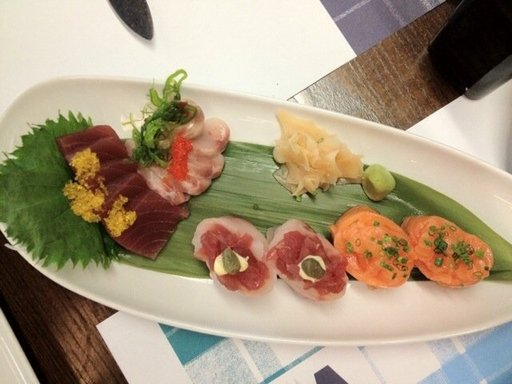

In [12]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image ...)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Text(0.5, 1.0, 'Image class: sushi | Image shape: (384, 512, 3) -> [height, width, color_channales] (HWC)')

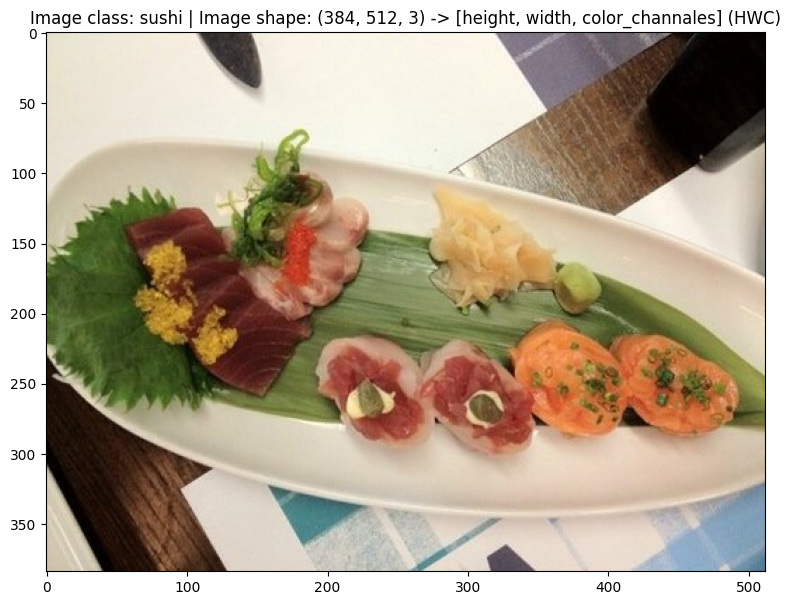

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channales] (HWC)")

In [16]:
img_as_array

array([[[227, 225, 204],
        [227, 225, 204],
        [227, 225, 204],
        ...,
        [  4,   3,   0],
        [  5,   4,   0],
        [  5,   4,   0]],

       [[225, 223, 202],
        [226, 224, 203],
        [226, 224, 203],
        ...,
        [  4,   3,   0],
        [  4,   3,   0],
        [  5,   4,   0]],

       [[225, 223, 202],
        [225, 223, 202],
        [226, 224, 203],
        ...,
        [  4,   3,   0],
        [  4,   3,   0],
        [  5,   4,   0]],

       ...,

       [[205, 193, 167],
        [205, 193, 167],
        [205, 193, 167],
        ...,
        [ 95, 129, 156],
        [ 90, 124, 149],
        [ 90, 124, 149]],

       [[205, 193, 167],
        [204, 192, 166],
        [204, 192, 166],
        ...,
        [ 95, 126, 154],
        [ 89, 121, 146],
        [ 89, 121, 146]],

       [[205, 193, 167],
        [205, 193, 167],
        [205, 193, 167],
        ...,
        [ 90, 121, 149],
        [ 84, 116, 141],
        [ 84, 116, 141]]

#3. Data Transformation

In [17]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [18]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our image to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [19]:
data_transform(img).shape

torch.Size([3, 64, 64])

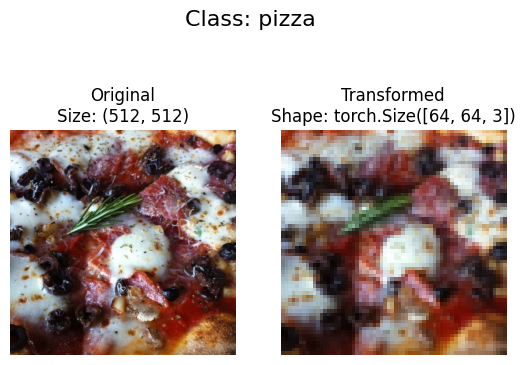

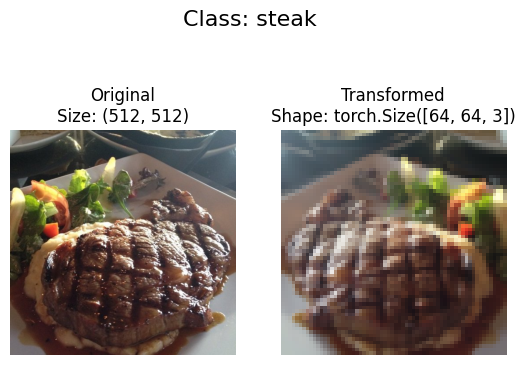

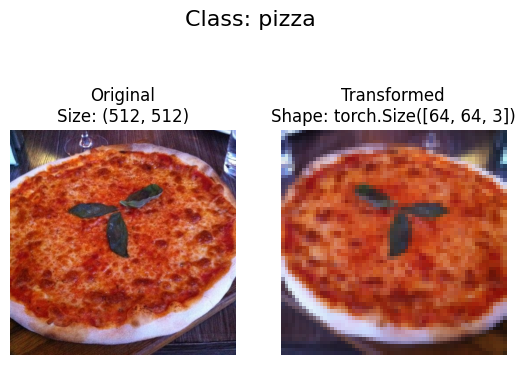

In [23]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them, then plots the original vs. the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for many ...
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

#4. Option 1: Loading Image Data Using ImageFolder

In [24]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [25]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [26]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [27]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [28]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [29]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [30]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

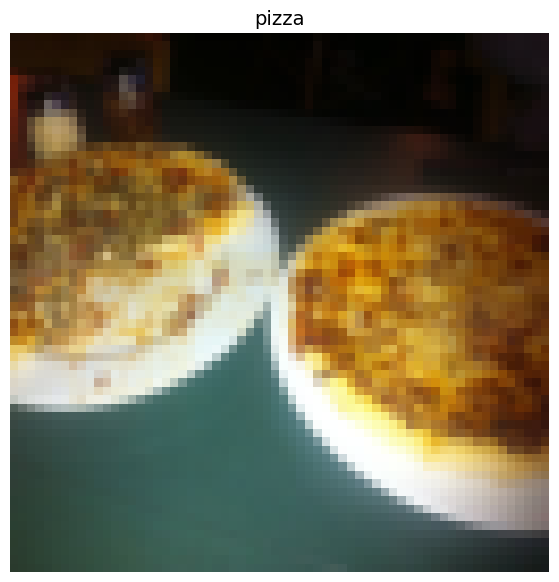

In [31]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [34]:
import os
os.cpu_count()

2

In [35]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x780312e4ded0>,
 <torch.utils.data.dataloader.DataLoader at 0x780312bdfcd0>)

In [36]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [37]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


#5. Option 2: Loading Image Data with a Custom Dataset

In [38]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [39]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [40]:
# setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [41]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'steak'>, <DirEntry 'pizza'>]

In [42]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory} ... please check file structure")

  # 3. Create a directory of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [43]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [64]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    #3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens and image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/ ...
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [65]:
img, label = train_data[0]

In [66]:
img, label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [67]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()])

In [68]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [69]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x780313083c40>,
 <__main__.ImageFolderCustom at 0x780313083b50>)

In [70]:
len(train_data), len(train_data_custom)

(225, 225)

In [71]:
len(test_data), len(test_data_custom)

(75, 75)

In [72]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [73]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [76]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


In [77]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, n shouldn't be larger than 10, setting to 10 and removing shape ...")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
      plt.title(title)

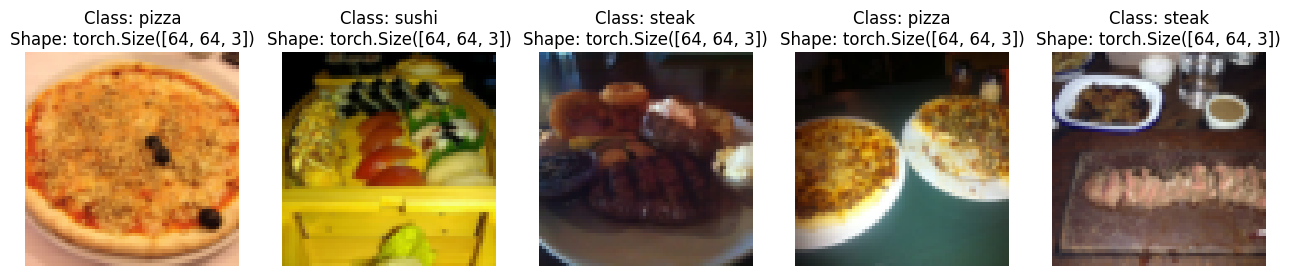

In [78]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

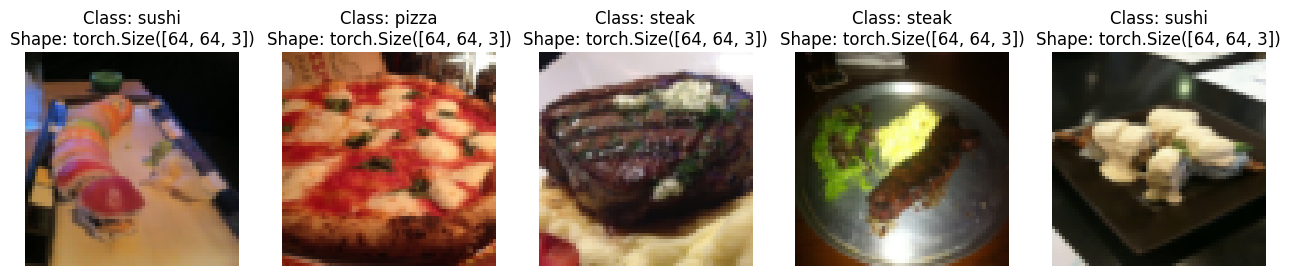

In [79]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

In [80]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x780312ae5780>,
 <torch.utils.data.dataloader.DataLoader at 0x780312d8c040>)

In [81]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

#6. Other Forms of Transforms (Data Augmentation)

In [82]:
# Let's look at trivailaugment - https://pytorch.org/vision/stable/auto_examples/plot_transforms.html
from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor()])

In [83]:
image_path

PosixPath('data/pizza_steak_sushi')

In [84]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/2120573.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2813454.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1214108.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2590819.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/765684.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/14046.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3004029.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1552504.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2980779.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1232045.jpg')]

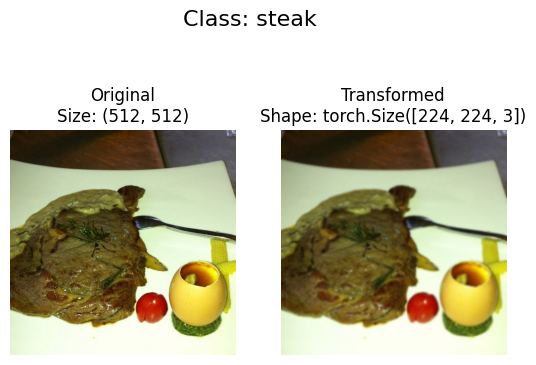

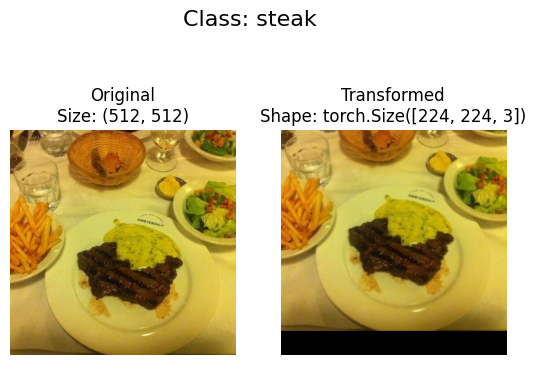

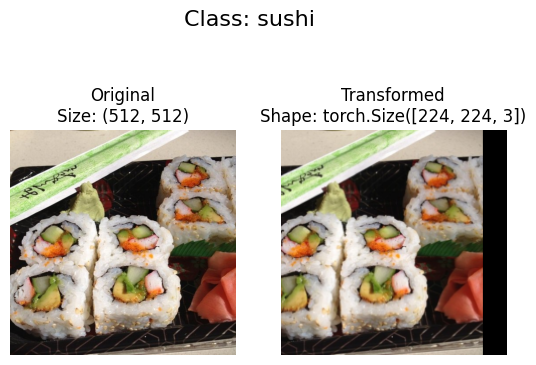

In [85]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

#7. Model 0: TinyVGG w/o Data Augmentation

In [86]:
# Create simple transform
simple_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()])

In [87]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [108]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: http

In [109]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [110]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [111]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [112]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [113]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn (y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [114]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [118]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss & accuracy ...
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

In [119]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697
Epoch: 2 | Train loss: 1.0868 | Train acc: 0.4883 | Test loss: 1.0807
Epoch: 3 | Train loss: 1.0843 | Train acc: 0.4023 | Test loss: 1.0608
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4102 | Test loss: 1.0656
Total training time: 12.998 seconds


In [120]:
model_0_results

{'train_loss': [1.106319099664688,
  1.0998046845197678,
  1.086849331855774,
  1.0843025892972946,
  1.0662314146757126],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.41015625],
 'test_loss': [1.0983206431070964,
  1.06969157854716,
  1.0807159344355266,
  1.0607701937357585,
  1.0655529896418254],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

In [121]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [126]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

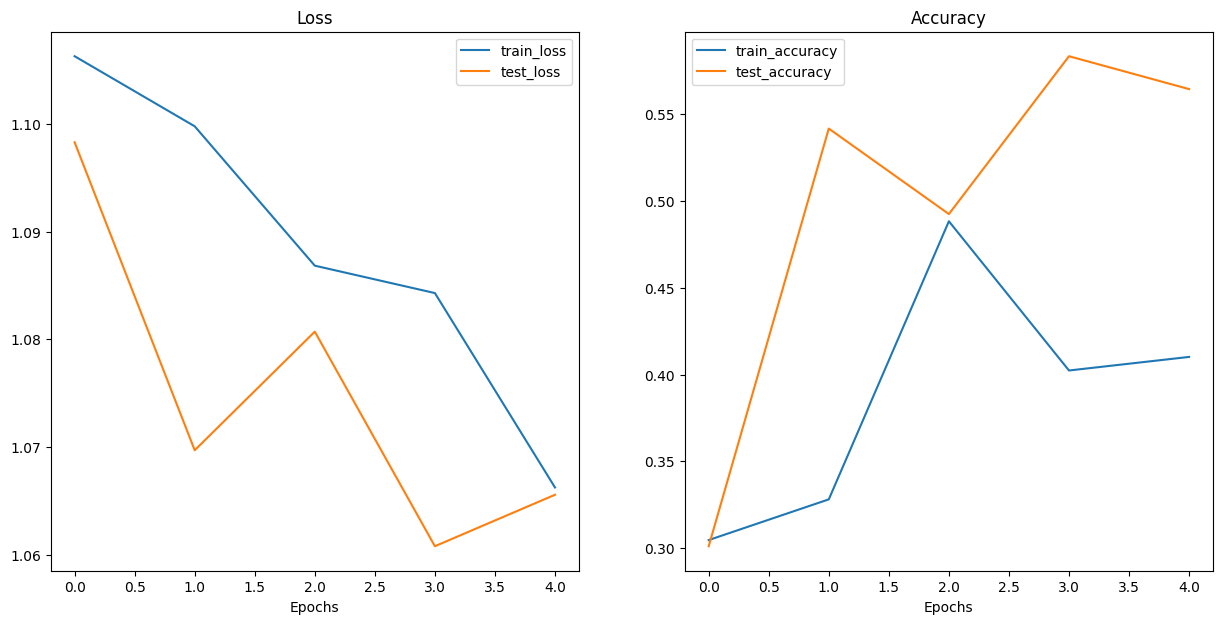

In [127]:
plot_loss_curves(model_0_results)

#8. What should an ideal Loss Curve should look like?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

#9. Model 1: TinyVGG with Data Augmentation

In [128]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([transforms.Resize(size=(64, 64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()])

test_transform_simple = transforms.Compose([transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()])

In [129]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [130]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [131]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [132]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1261
Epoch: 2 | Train loss: 1.0712 | Train acc: 0.4258 | Test loss: 1.1593
Epoch: 3 | Train loss: 1.1253 | Train acc: 0.3047 | Test loss: 1.1581
Epoch: 4 | Train loss: 1.0864 | Train acc: 0.4258 | Test loss: 1.1555
Total training time for model_1: 10.903 seconds


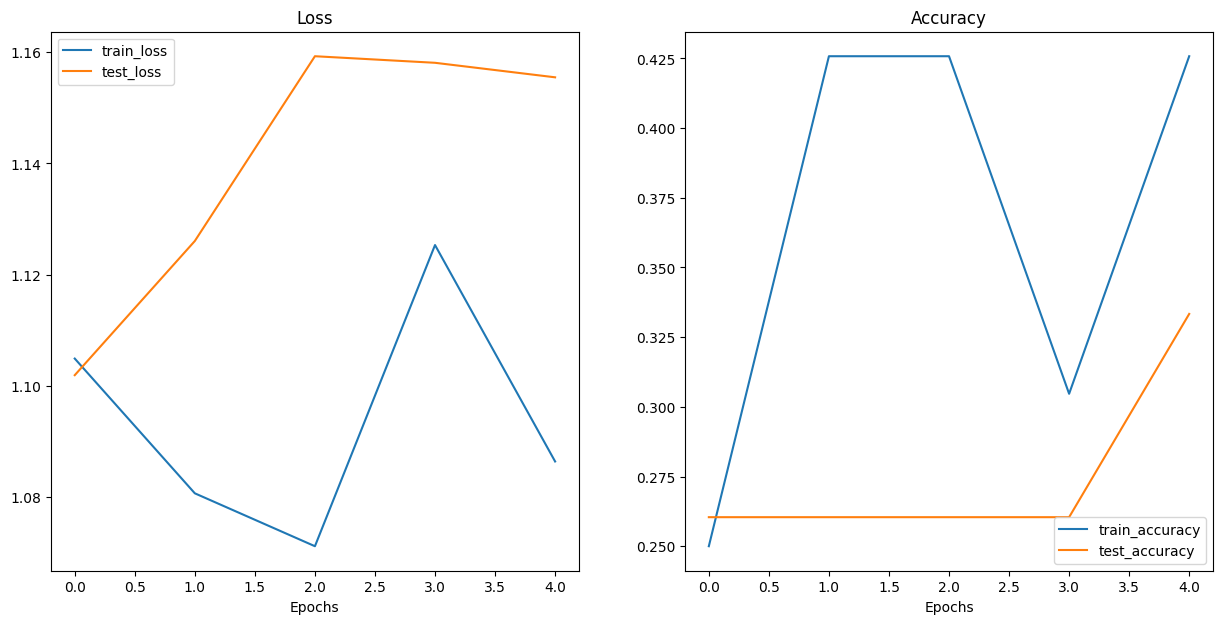

In [133]:
plot_loss_curves(model_1_results)

#10. Compare Model Results

In [134]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099805,0.328125,1.069692,0.541667
2,1.086849,0.488281,1.080716,0.492424
3,1.084303,0.402344,1.060770,0.583333
4,1.066231,0.410156,1.065553,0.564394


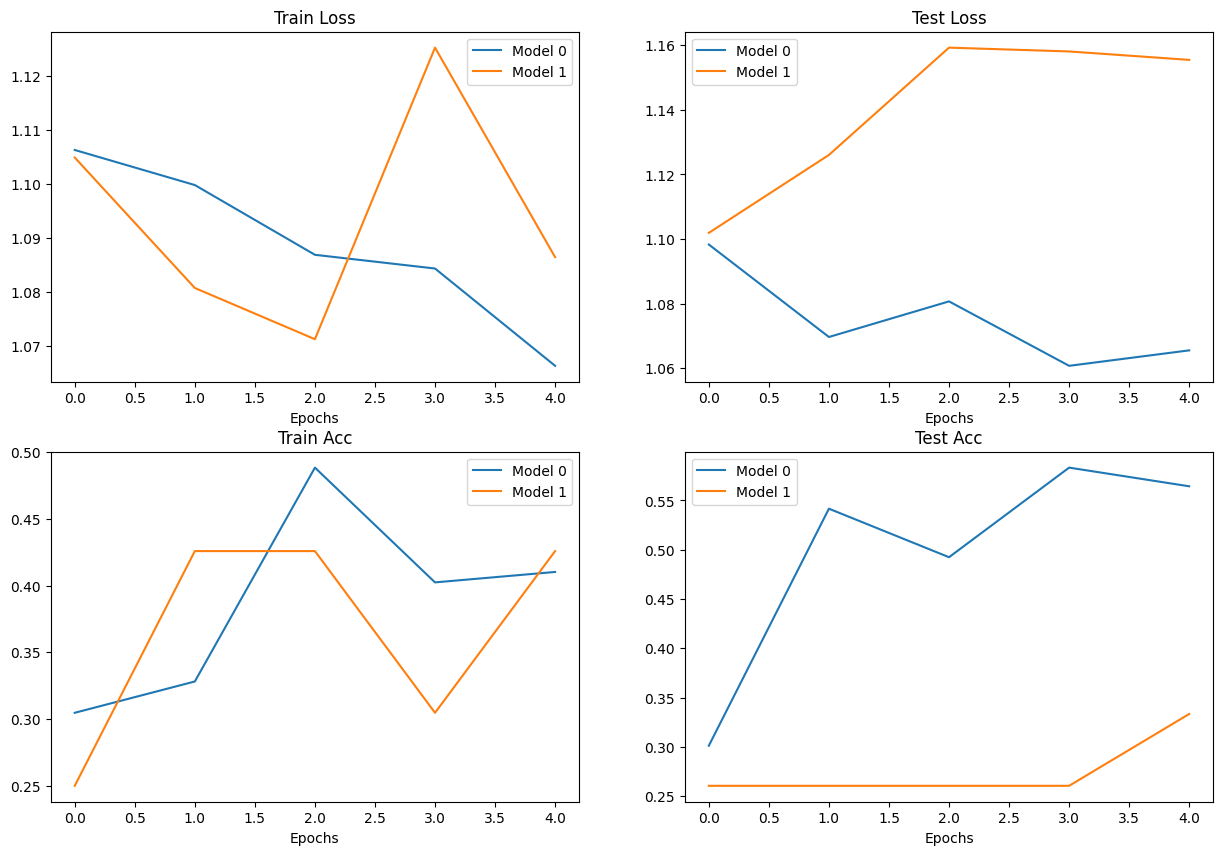

In [135]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()

#11. Make Predictions on Custom Images

In [156]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path/"04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


In [163]:
custom_image_path

PosixPath('data/04-pizza-dad.jpeg')

In [167]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

RuntimeError: ignored

In [ ]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

In [ ]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

In [ ]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

In [ ]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

In [ ]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([transforms.Resize(size=(64, 64))])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [ ]:
# This will error: image not on right device
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed)

In [ ]:
# This will error: no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

In [ ]:
custom_image_transformed.shape, custome_image_transformed.unsqueeze(0).shape

In [ ]:
# This should work? (added a batch size ...)
model_1.eval()
with torch.inference_mode()
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

In [ ]:
# Convert Logits -> Pred Probs
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

In [ ]:
# Convert Pred Probs -> Pred Labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

In [ ]:
class_names[custom_image_pred_label]

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sute the model is on the target device
  model.to(device)

  # Turn on eval / inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict ...)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the right ...

  # Convert Logits -> Pred Probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert Pred Probs -> Pred Labels
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape
  if class_names:
    title =f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.cpu()}"
  else:
    title =f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

In [ ]:
# Pred on our custom image
pred_and_plot image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)